**METRO DATASET**



---
**Without Transform**


---





**STEP** 1

In [ ]:
#importing all libs

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler
import random
import torch
import torch.nn as nn

In [ ]:


# --- Set seeds here! ---
seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#--- Now we can do everything else ---
# Split dataset, create DataLoaders, initialize model, etc.


In [ ]:
!git clone https://github.com/EnfangCui/MetroDataset.git  #cloning into dataset

Cloning into 'MetroDataset'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 73 (delta 15), reused 0 (delta 0), pack-reused 19 (from 1)
Receiving objects: 100% (73/73), 87.02 MiB | 19.46 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
import zipfile
import os

base_path = '/content/MetroDataset'
failure_path = os.path.join(base_path, 'Failure')
normal_path = os.path.join(base_path, 'Normal')

#os code for extracting from zip files
def extract_zip_files(folder_path):
    for zip_file in os.listdir(folder_path):
        if zip_file.endswith('.zip'):
            folder_name = zip_file.replace('.zip', '')
            if not os.path.exists(os.path.join(folder_path, folder_name)):
                print(f"Extracting {zip_file}...")
                with zipfile.ZipFile(os.path.join(folder_path, zip_file), 'r') as zip_ref:
                    zip_ref.extractall(folder_path)
                print(f"Extraction of {zip_file} complete.")
            else:
                print(f"{folder_name} already exists, skipping extraction.")

# Extract files
extract_zip_files(failure_path)
extract_zip_files(normal_path)

Extracting Metro_vibration_v1_y_axis_failure.zip...
Extraction of Metro_vibration_v1_y_axis_failure.zip complete.
Extracting Metro_vibration_v1_z_axis_failure.zip...
Extraction of Metro_vibration_v1_z_axis_failure.zip complete.
Extracting Metro_vibration_v1_x_axis_failure.zip...
Extraction of Metro_vibration_v1_x_axis_failure.zip complete.
Extracting Metro_vibration_v1_z_axis_normal.zip...
Extraction of Metro_vibration_v1_z_axis_normal.zip complete.
Extracting Metro_vibration_v1_y_axis_normal.zip...
Extraction of Metro_vibration_v1_y_axis_normal.zip complete.
Extracting Metro_vibration_v1_x_axis_normal.zip...
Extraction of Metro_vibration_v1_x_axis_normal.zip complete.


In [ ]:
failure_files = [os.path.join(failure_path, f) for f in os.listdir(failure_path) if f.endswith('.csv')]  #
failure_dfs = [pd.read_csv(file) for file in failure_files]

normal_files = [os.path.join(normal_path, f) for f in os.listdir(normal_path) if f.endswith('.csv')]
normal_dfs = [pd.read_csv(file) for file in normal_files]

failure_dfs = []
for file in failure_files:
    try:
        df = pd.read_csv(file)
        failure_dfs.append(df)
    except Exception as e:
        print(f"Error loading {file}: {e}") # check if there are any corrupted files within the CSV files

normal_dfs = []
for file in normal_files:
    try:
        df = pd.read_csv(file)
        normal_dfs.append(df)
    except Exception as e:
        print(f"Error loading {file}: {e}") # to check if there are any corrupted files within the CSV files

In [ ]:
failure_x_path = os.path.join('/content/MetroDataset/Failure/Metro_vibration_v1_x_axis_failure.csv')
failure_y_path = os.path.join('/content/MetroDataset/Failure/Metro_vibration_v1_y_axis_failure.csv')
failure_z_path = os.path.join('/content/MetroDataset/Failure/Metro_vibration_v1_z_axis_failure.csv')

normal_x_path = os.path.join('/content/MetroDataset/Normal/Metro_vibration_v1_x_axis_normal.csv')
normal_y_path = os.path.join('/content/MetroDataset/Normal/Metro_vibration_v1_y_axis_normal.csv')
normal_z_path = os.path.join('/content/MetroDataset/Normal/Metro_vibration_v1_z_axis_normal.csv')

# Load the data assuming the first column is the index
failure_x = pd.read_csv(failure_x_path, index_col=0) #index coloumn 0 means the dataframe will contain an index coloumn
failure_y = pd.read_csv(failure_y_path, index_col=0)
failure_z = pd.read_csv(failure_z_path, index_col=0)

normal_x = pd.read_csv(normal_x_path, index_col=0)
normal_y = pd.read_csv(normal_y_path, index_col=0)
normal_z = pd.read_csv(normal_z_path, index_col=0)
print(len(failure_x))
print(len(normal_x ))

6231040
3635200


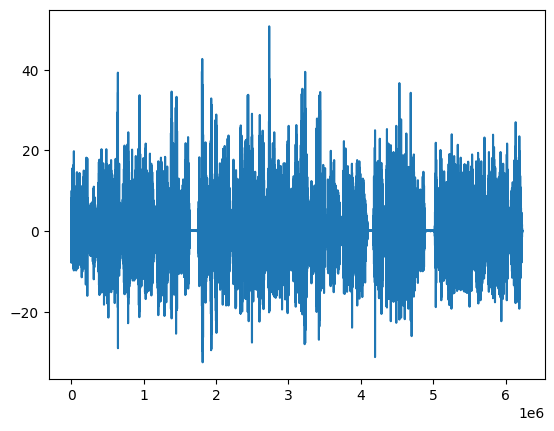

In [ ]:
import matplotlib.pyplot as plt
plt.plot(failure_x)

plt.show()

In [ ]:
# Concatenate the failure and normal data with multi-index
data_1 = pd.concat([failure_x, normal_x], keys=['failure', 'normal'])
data_2 = pd.concat([failure_y, normal_y], keys=['failure', 'normal'])
data_3 = pd.concat([failure_z, normal_z], keys=['failure', 'normal'])
print(data_1)


print(data_1.shape,data_2.shape,data_3.shape)


                 x_data/g
        index            
failure 0            -0.4
        1            -0.4
        2            -0.6
        3            -0.2
        4             0.3
...                   ...
normal  3635195       1.6
        3635196       2.7
        3635197       1.0
        3635198      -0.8
        3635199       0.1

[9866240 rows x 1 columns]
(9866240, 1) (9866240, 1) (9866240, 1)


In [ ]:
# Reset multi-index to flatten the 'Condition' label into a column
data_1 = data_1.reset_index(level=0).rename(columns={'level_0': 'Condition'})
data_2 = data_2.reset_index(level=0).rename(columns={'level_0': 'Condition'})
data_3 = data_3.reset_index(level=0).rename(columns={'level_0': 'Condition'})


print(data_1.shape,data_2.shape,data_3.shape)

(9866240, 2) (9866240, 2) (9866240, 2)


In [ ]:
print(data_1.columns)
print(data_2.columns)
print(data_3.columns)

Index(['Condition', 'x_data/g'], dtype='object')
Index(['Condition', 'y_data/g'], dtype='object')
Index(['Condition', 'z_data/g'], dtype='object')


In [ ]:
data_1.head(10)

,Condition,x_data/g
index,,
0,failure,-0.4
1,failure,-0.4
2,failure,-0.6
3,failure,-0.2
4,failure,0.3
5,failure,0.7
6,failure,0.7
7,failure,-0.7
8,failure,-0.4


In [ ]:
data_1.tail(10)

,Condition,x_data/g
index,,
3635190,normal,-1.6
3635191,normal,-0.5
3635192,normal,0.8
3635193,normal,0.9
3635194,normal,1.7
3635195,normal,1.6
3635196,normal,2.7
3635197,normal,1.0
3635198,normal,-0.8


In [ ]:
# Merge X, Y, and Z axis data on the same index (drop duplicate 'Condition' columns)
merged_data = pd.concat([data_1, data_2.drop('Condition', axis=1), data_3.drop('Condition', axis=1)], axis=1)

# Rename columns for clarity
merged_data.columns = ['Condition', 'x_axis', 'y_axis', 'z_axis']

# Encode 'Condition' as numerical labels (0 for Failure, 1 for Normal)
merged_data['Condition'] = merged_data['Condition'].map({'failure': 0, 'normal': 1})

# Check the merged data
print(merged_data.head(1000))

# Save the final merged data for future use
#merged_data.to_csv('merged_vibration_data.csv', index=True)

       Condition  x_axis  y_axis  z_axis
index                                   
0              0    -0.4    -0.6    -0.0
1              0    -0.4    -0.3    -0.1
2              0    -0.6    -0.1    -0.1
3              0    -0.2    -0.2     0.1
4              0     0.3    -0.5     0.1
...          ...     ...     ...     ...
995            0     0.9     1.1     0.3
996            0     0.1     0.3    -0.0
997            0    -0.8    -0.1    -0.2
998            0    -1.9     0.3    -0.1
999            0    -1.6    -0.4    -0.1

[1000 rows x 4 columns]


In [ ]:


# Count for the number of 0 values in the 'Condition' column
zero_count = (merged_data['Condition'] == 0).sum()
print(f"Number of 0 values (Failure) in 'Condition' column: {zero_count}")


Number of 0 values (Failure) in 'Condition' column: 6231040


In [ ]:
one_count= (merged_data['Condition'] == 1).sum()
print(f"Number of 1 values (Normal) in 'Condition' column: {one_count}")

Number of 1 values (Normal) in 'Condition' column: 3635200


In [ ]:

# Split the merged data into two dataframes based on the 'Condition' column
failure_data_merged = merged_data[merged_data['Condition'] == 0]
normal_data_merged= merged_data[merged_data['Condition'] == 1]

# Print the shapes of the new dataframes to verify the split
print("Shape of failure_df:", failure_data_merged.shape)
print("Shape of normal_df:", normal_data_merged.shape)


Shape of failure_df: (6231040, 4)
Shape of normal_df: (3635200, 4)


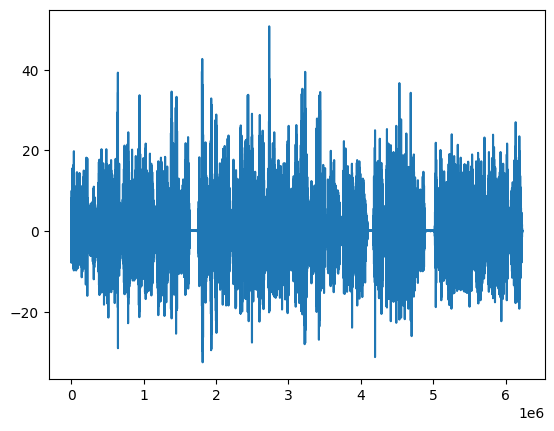

In [ ]:
plt.plot(failure_data_merged['x_axis'])
plt.show()
#np.unique(failure_data_merged['x_axis']-failure_x)

In [ ]:
# Saving the final merged data for future use
#failure_data_merged.to_csv('failure_data.csv', index=True)

In [ ]:
failure_data_merged.shape

(6231040, 4)

In [ ]:
normal_data_merged.shape

(3635200, 4)

In [ ]:

def energy(df):
  """
  Calculateing the sum of squares of 'x_axis', 'y_axis', and 'z_axis' columns.

  Args:
    df: A pandas DataFrame with 'x_axis', 'y_axis', and 'z_axis' columns.

  Returns:
    A float representing the sum of squares.
  """
  return ((df['x_axis'] ** 2) + (df['y_axis'] ** 2) + (df['z_axis'] ** 2)).sum()


In [ ]:


def slice(start_index):

  if start_index < 0 or start_index >= len(failure_data_merged):
    print("Invalid start index.")
    return None

  end_index = min(start_index + 1024, len(failure_data_merged))
  return failure_data_merged.iloc[start_index:end_index].drop(columns=['Condition'])


In [ ]:
def slice_fn(start_index):
  """
  Slices the failure_data_merged DataFrame.

  Args:
    start_index: The starting index for the slice.

  Returns:
    A Pandas DataFrame containing 1024 rows starting from start_index.
    Returns None if the start_index is invalid.
  """
  if start_index < 0 or start_index >= len(normal_data_merged):
    print("Invalid start index.")
    return None

  end_index = min(start_index + 1024, len(normal_data_merged))
  return normal_data_merged.iloc[start_index:end_index].drop(columns=['Condition'])


In [ ]:


def dataframe_to_numpy(df):
  """Converts a Pandas DataFrame to a NumPy array.

  Args:
    df: The input Pandas DataFrame.

  Returns:
    A NumPy array representing the DataFrame's data, or None if an error occurs.
  """
  try:
    return df.to_numpy()
  except Exception as e:
    print(f"Error converting DataFrame to NumPy array: {e}")
    return None


In [ ]:


import numpy as np

failure_3d_array = []
normal_3d_array= []


In [ ]:
#for i in random.sample(range(1, len(failure_data_merged)-1024), 10000):
  #if energy(slice(i)) >= 0.1:
    #failure_3d_array.append(slice(i).to_numpy())

In [ ]:

#   if energy(slice(i)) >= 0.1:
#     failure_3d_array.append(slice(i).to_numpy())
# change this, add break or some functionn such that after the loop i should get 10000 values in the array

failure_3d_array = []
count = 0
for i in random.sample(range(1, len(failure_data_merged) - 1024), 20000):
    if energy(slice(i)) >= 0.1:
        failure_3d_array.append(slice(i).to_numpy())
        count += 1
    if count == 10000:
        break


In [ ]:
failure_3d_array=np.array(failure_3d_array)

In [ ]:
failure_3d_array.shape

(10000, 1024, 3)

In [ ]:
normal_3d_array = []
count = 0
for i in random.sample(range(1, len(normal_data_merged) - 1024), 20000):
    if energy(slice_fn(i)) >= 0.1:
        normal_3d_array.append(slice_fn(i).to_numpy())
        count += 1
    if count == 10000:
        break


In [ ]:
normal_3d_array=np.array(normal_3d_array)

In [ ]:
normal_3d_array.shape

(10000, 1024, 3)

In [ ]:
# np.save('/content/normal_3d_array_update.npy', normal_3d_array)
# np.save('/content/failure_3d_array_update.npy', failure_3d_array)



---



In [ ]:
import numpy as np

# normal_array = np.load('/content/normal_3d_array_update.npy', mmap_mode='r')
# failure_array = np.load('/content/failure_3d_array_update.npy', mmap_mode='r')

print(normal_3d_array.shape)
print(failure_3d_array.shape)

(10000, 1024, 3)
(10000, 1024, 3)




---



**STEP 2**


In [ ]:
normal_3d_array=normal_3d_array.transpose(0,2,1)
failure_3d_array=failure_3d_array.transpose(0,2,1)





In [ ]:
failure_3d_array.shape


(10000, 3, 1024)

In [ ]:
normal_3d_array.shape

(10000, 3, 1024)

In [ ]:


#saving them
np.save('failure_3d_array.npy', failure_3d_array)
np.save('normal_3d_array.npy', normal_3d_array)

In [ ]:
from collections.abc import ItemsView


class Dataset:
    def __init__(self, normal_array_path, failure_array_path):
        self.normal_array = np.load(normal_array_path, mmap_mode='r')
        self.failure_array = np.load(failure_array_path, mmap_mode='r')

    def __len__(self):
        return len(self.normal_array) + len(self.failure_array)

    def __getitem__(self, idx):
        if idx<len(self.normal_array):
          data=self.normal_array[idx,:,:]
          label=1
        if idx>=len(self.normal_array):
          data=self.failure_array[idx-len(self.normal_array),:,:]
          label=0
        return data,label





In [ ]:

from torch.utils.data import DataLoader

import time

start= time.time()
### Your code goes here #################################################################################################




# Create the dataset
dataset = Dataset('/content/normal_3d_array.npy', '/content/failure_3d_array.npy')

# Create a DataLoader
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Iterate through the DataLoader
for batch_idx, (data, labels) in enumerate(dataloader):
    print(f"Batch {batch_idx}: Data shape: {data.shape}, Labels shape: {labels.shape}")
    # Now you have batches of data and labels ready for your model
    #model training code here ...
    break #remove to run through the entire dataloader

#################################################################################################################################

end = time.time()
print("Time taken", end- start)


Batch 0: Data shape: torch.Size([100, 3, 1024]), Labels shape: torch.Size([100])
Time taken 0.07371234893798828


/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


In [ ]:
#checking the size of the file in memory
import sys
print(f'y_train memory occupied: {sys.getsizeof(dataset)} bytes')

y_train memory occupied: 56 bytes


In [ ]:


class ConvNet(nn.Module):
    def __init__(self, in_channels=3):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64 * 256, 128) # Adjust input size based on pooling
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1) # Output size 1 for binary classification
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 256)  # Adjust input size based on pooling
        x = self.relu3(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


model = ConvNet()
#print(model(failure_tensor).shape) # Now it should print a valid shape
# Example forward pass (replace with our actual input)
#output = model(failure_tensor[0].unsqueeze(0))  # Unsqueezingto add a batch dimension
#print(output)



# Example usage (assuming your data is in 'failure_array'):
# Reshape the data to (samples, channels, length)
#failure_array = failure_array.reshape(failure_array.shape[0], 3, 1024) # Correct the reshape
#normal_array = normal_array.reshape(normal_array.shape[0], 3, 1024)

# Convert NumPy arrays to PyTorch tensors
#failure_tensor = torch.tensor(failure_array, dtype=torch.float32)
# Instantiate the model

In [ ]:


# # Reshape your data to have the correct dimensions for the CNN
# failure_array = failure_array.reshape(failure_array.shape[0], 3, 1024)

# # Select a single sample to pass to the model
# x = failure_array[0]

# # Pass the data to the model and print the output size
# print(model(torch.tensor(x, dtype=torch.float32)).size())


In [ ]:

# import torch
# import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Split the dataset into training and testing sets
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# # Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Instantiate the model, optimizer, and loss function
# model = ConvNet()
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss


In [ ]:
#Training loop with early stopping
num_epochs = 10  #Adjust as needed
patience = 1  #Number of epochs with no improvement after which training will be stopped
best_accuracy = 0
epochs_no_improve = 0

# Training
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for data, labels in train_loader:
        #data = data.to(torch.complex64)
        data = data.float()
        labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
        # print(f"Batch {batch_idx} - Data shape: {data.shape}, Labels shape: {labels.shape}, Data type: {data.dtype}, Labels shape: {labels.dtype}")

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluation
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.float()  # convert data to float
            #data = data.to(torch.complex64)
            labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predictions = (outputs > 0.5).float()  # convert output to 0,1 values
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predictions == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")



     # Early stopping check
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        epochs_no_improve = 0
        # Save the model weights
        torch.save(model.state_dict(), 'best_model_weights.pth')
    else:
        epochs_no_improve += 1
    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Confusion Matrix (optional - uncomment if you want to see it per epoch)
    # cm = confusion_matrix(all_labels, all_predictions)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
    #             xticklabels=['Predicted Failure', 'Predicted Normal'],
    #             yticklabels=['Actual Failure', 'Actual Normal'])
    # plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    # plt.show()

Epoch 1/10, Train Loss: 0.4497, Train Acc: 79.69%, Test Loss: 0.3558, Test Acc: 84.28%
Epoch 2/10, Train Loss: 0.3144, Train Acc: 86.43%, Test Loss: 0.2812, Test Acc: 87.65%
Epoch 3/10, Train Loss: 0.2087, Train Acc: 92.89%, Test Loss: 0.1797, Test Acc: 94.03%
Epoch 4/10, Train Loss: 0.1628, Train Acc: 94.45%, Test Loss: 0.1677, Test Acc: 94.55%
Epoch 5/10, Train Loss: 0.1506, Train Acc: 94.81%, Test Loss: 0.1804, Test Acc: 93.85%
Early stopping at epoch 5


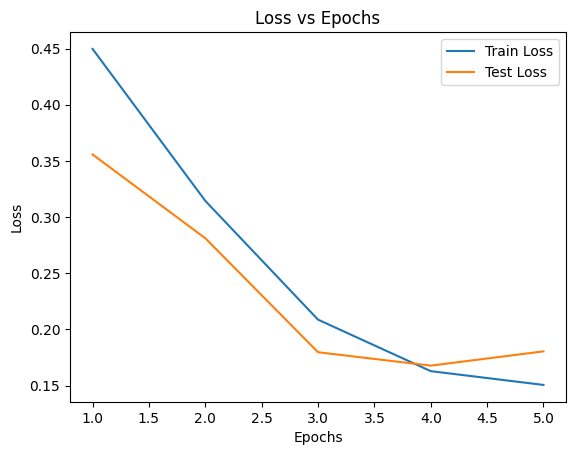

In [ ]:
# Plot the loss vs epochs
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(train_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()


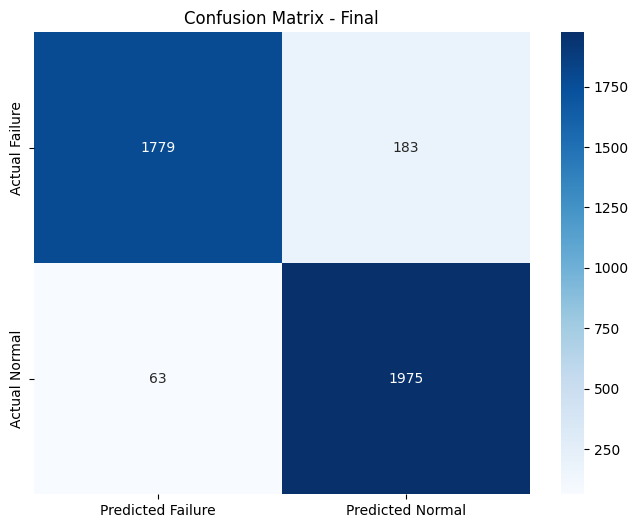

In [ ]:


#  ( existing code)

# (modified to print confusion matrix only once)


# Confusion Matrix (printed only once after all epochs)
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Failure', 'Predicted Normal'],
            yticklabels=['Actual Failure', 'Actual Normal'])
plt.title("Confusion Matrix - Final") # Added - Final to indicate it is the last epoch
plt.show()


In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.9152
Recall: 0.9691
F1-Score: 0.9414


In [ ]:
# stop here

In [ ]:
# ###################################### ADDING THIS CODE CELL FOR WITH SEED CALCULATIONS ########################################

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, random_split
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# seeds = [0, 1, 42, 1234, 10]
# #seeds = [42, 1234, 10]

# for seed in seeds:
#     print(f"\nRunning training with seed: {seed}")
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     np.random.seed(seed)

#     test_size = int(0.2 * len(dataset))
#     train_size = len(dataset) - test_size
#     train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#     model = ConvNet()
#     criterion = nn.BCEWithLogitsLoss()
#     optimizer = optim.Adam(model.parameters(), lr=1e-3)

#     num_epochs = 10
#     patience = 5
#     best_accuracy = 0
#     epochs_no_improve = 0

#     train_losses = []
#     train_accuracies = []
#     test_losses = []
#     test_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0
#         correct_train = 0
#         total_train = 0

#         for data, labels in train_loader:
#             data = data.float()
#             data = (data - data.mean(dim=-1, keepdim=True)) / (data.std(dim=-1, keepdim=True) + 1e-6)
#             labels = labels.float().unsqueeze(1)

#             optimizer.zero_grad()
#             outputs = model(data)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()
#             predicted = (torch.sigmoid(outputs) > 0.5).float()
#             total_train += labels.size(0)
#             correct_train += (predicted == labels).sum().item()

#         train_accuracy = 100 * correct_train / total_train
#         train_losses.append(train_loss / len(train_loader))
#         train_accuracies.append(train_accuracy)

#         model.eval()
#         test_loss = 0
#         correct_test = 0
#         total_test = 0
#         all_predictions = []
#         all_labels = []

#         with torch.no_grad():
#             for data, labels in test_loader:
#                 if data.ndim == 2:
#                     data = data.unsqueeze(1)
#                 elif data.ndim == 4:
#                     data = data.squeeze(1)
#                 data = data.float()
#                 data = (data - data.mean(dim=-1, keepdim=True)) / (data.std(dim=-1, keepdim=True) + 1e-6)
#                 labels = labels.float().unsqueeze(1)

#                 outputs = model(data)
#                 loss = criterion(outputs, labels)
#                 test_loss += loss.item()
#                 predictions = (torch.sigmoid(outputs) > 0.5).float()
#                 all_predictions.extend(predictions.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())
#                 total_test += labels.size(0)
#                 correct_test += (predictions == labels).sum().item()

#         test_accuracy = 100 * correct_test / total_test
#         test_losses.append(test_loss / len(test_loader))
#         test_accuracies.append(test_accuracy)

#         print(f"Epoch {epoch+1}/{num_epochs}, "
#               f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
#               f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

#         if test_accuracy > best_accuracy:
#             best_accuracy = test_accuracy
#             epochs_no_improve = 0
#             torch.save(model.state_dict(), f'best_model_seed_{seed}.pth')
#         else:
#             epochs_no_improve += 1
#             if epochs_no_improve == patience:
#                 print(f"Early stopping at epoch {epoch+1}")
#                 break

#     plt.figure()
#     plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
#     plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title(f'Loss vs Epochs (Seed: {seed})')
#     plt.legend()
#     plt.show()

#     cm = confusion_matrix(all_labels, all_predictions)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#                 xticklabels=['Predicted Failure', 'Predicted Normal'],
#                 yticklabels=['Actual Failure', 'Actual Normal'])
#     plt.title(f"Confusion Matrix - Final (Seed: {seed})")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.show()

#     precision = precision_score(all_labels, all_predictions)
#     recall = recall_score(all_labels, all_predictions)
#     f1 = f1_score(all_labels, all_predictions)

#     print(f"\n[Metrics for Seed {seed}]")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall:    {recall:.4f}")
#     print(f"F1-Score:  {f1:.4f}")


In [ ]:
# stop here

In [ ]:
# for seed in seeds:
#     print(f"\nRunning training with seed: {seed}")
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     np.random.seed(seed)

#     test_size = int(0.2 * len(dataset))
#     train_size = len(dataset) - test_size
#     train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#     model = ConvNet()
#     criterion = nn.BCEWithLogitsLoss()
#     optimizer = optim.Adam(model.parameters(), lr=1e-3)

#     # Training loop with early stopping
#     num_epochs = 10  # Adj
#     patience = 1  # Number of epochs with no improvement after which training will be stopped
#     best_accuracy = 0
#     epochs_no_improve = 0

#     # Training
#     train_losses = []
#     train_accuracies = []
#     test_losses = []
#     test_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0
#         correct_train = 0
#         total_train = 0
#             for data, labels in train_loader:
#                 data = data.float()  # convert data to float
#                 #data = data.to(torch.complex64)
#                 labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
#                 optimizer.zero_grad()
#                 outputs = model(data)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()

#                 train_loss += loss.item()
#                 predicted = (outputs > 0.5).float()
#                 total_train += labels.size(0)
#                 correct_train += (predicted == labels).sum().item()

#                 train_accuracy = 100 * correct_train / total_train
#                 train_losses.append(train_loss / len(train_loader))
#                 train_accuracies.append(train_accuracy)

#                 # Evaluation
#                 model.eval()
#                 test_loss = 0
#                 correct_test = 0
#                 total_test = 0
#                 all_predictions = []
#                 all_labels = []
#                 with torch.no_grad():
#                     for data, labels in test_loader:
#                         data = data.float()  # convert data to float
#                         labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
#                         outputs = model(data)
#                         loss = criterion(outputs, labels)
#                         test_loss += loss.item()
#                         predictions = (outputs > 0.5).float()  # convert output to 0,1 values
#                         all_predictions.extend(predictions.cpu().numpy())
#                         all_labels.extend(labels.cpu().numpy())
#                         total_test += labels.size(0)
#                         correct_test += (predictions == labels).sum().item()

#                 test_accuracy = 100 * correct_test / total_test
#                 test_losses.append(test_loss / len(test_loader))
#                 test_accuracies.append(test_accuracy)


#         print(f"Epoch {epoch+1}/{num_epochs}, "
#               f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
#               f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")



#         # Early stopping check
#         if test_accuracy > best_accuracy:
#             best_accuracy = test_accuracy
#             epochs_no_improve = 0
#             # Save the model weights
#             torch.save(model.state_dict(), 'best_model_weights.pth')
#         else:
#             epochs_no_improve += 1
#         if epochs_no_improve == patience:
#             print(f"Early stopping at epoch {epoch+1}")
#             break






#     # Confusion Matrix (optional - uncomment if you want to see it per epoch)
#     # cm = confusion_matrix(all_labels, all_predictions)
#     # plt.figure(figsize=(8, 6))
#     # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#     #             xticklabels=['Predicted Failure', 'Predicted Normal'],
#     #             yticklabels=['Actual Failure', 'Actual Normal'])
#     # plt.title(f"Confusion Matrix - Epoch {epoch+1}")
#     # plt.show()





---





```
# This is formatted as code
```



---
**With Transform**

---




In [ ]:
# #sample
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_fft_from_array(data_array, label, sample_rate=1024):
#     plt.figure(figsize=(20, 18))

#     num_samples, num_timesteps, num_channels = data_array.shape
#     fft_freqs = np.fft.fftfreq(num_timesteps, d=1/sample_rate)
#     for ch in range(num_channels):
#         # plt.subplot(3, 1, ch + 1)
#         for i in range(num_samples):
#             signal = data_array[i, :, ch]
#             fft_vals = np.fft.fft(signal)
#             fft_db = 20 * np.log10(np.abs(fft_vals) + 1e-8)
#             plt.plot(fft_freqs[:num_timesteps // 2] * sample_rate,
#                      fft_db[:num_timesteps // 2], alpha=0.3)

#         plt.title(f'{label} FFT of Channel {ch + 1}', fontsize=14)
#         plt.xlabel('Frequency (Hz)', fontsize=12)
#         plt.ylabel('Amplitude (dB)', fontsize=12)
#         plt.legend([f'{label} Channel {ch + 1}'])
#         plt.grid(False)

#     plt.tight_layout(pad=3.0)
#     plt.show()

In [ ]:
from scipy.fft import dct  #
from scipy.fft import dst

In [ ]:
from collections.abc import ItemsView
from scipy.signal import hilbert

class Dataset_custom_transform(Dataset):
    def __init__(self, normal_array_path, failure_array_path, preprocessing_flag = 'None'):
        self.normal_array = np.load(normal_array_path, mmap_mode='r')
        self.failure_array = np.load(failure_array_path, mmap_mode='r')
        self.preprocessing_flag = preprocessing_flag

    def fft_function(self, data):
        num_channels, signal_length = data.shape
        fft_data = np.zeros_like(data, dtype=complex)
        for ch in range(num_channels):
            fft_data[ch, :] = np.fft.fft(data[ch, :])
        return fft_data


    def hilbert_function(self, data, fs=400):
        num_channels, signal_length = data.shape
        hilbert_data = np.zeros_like(data, dtype=complex)
        for ch in range(num_channels):
            hilbert_data[ch, :] = hilbert(data[ch, :])
        return hilbert_data

    def dct_function(self, data):
        num_channels, signal_length = data.shape
        dct_data = np.zeros_like(data)
        for ch in range(num_channels):
            dct_data[ch, :] = dct(data[ch, :], type=2)  # Using DCT-II
        return dct_data

    def dst_function(self, data):
        num_channels, signal_length = data.shape
        dst_data = np.zeros_like(data)
        for ch in range(num_channels):
            dst_data[ch, :] = dst(data[ch, :], type=2)  # Using DST-II
        return dst_data

    def wavelet_function(self, data, wavelet='haar', level=1):
        import pywt
        num_channels, signal_length = data.shape
        wavelet_data = []
        for ch in range(num_channels):
            coeffs = pywt.wavedec(data[ch, :].copy(), wavelet, level=level)
            # We will concatenate the coefficients for each channel
            wavelet_data.append(np.concatenate(coeffs))
        # Pad or truncate to a consistent size if needed, or handle variable lengths
        # For simplicity, we will just return the list of concatenated coefficients
        # This might require adjustments depending on the CNN input requirements
        # For a fixed output size, you might need padding/truncation
        # Example of padding to the max length:
        max_len = max(len(coeff_array) for coeff_array in wavelet_data)
        padded_wavelet_data = np.zeros((num_channels, max_len))
        for ch, coeff_array in enumerate(wavelet_data):
            padded_wavelet_data[ch, :len(coeff_array)] = coeff_array

        return padded_wavelet_data

    def __len__(self):
        return len(self.normal_array) + len(self.failure_array)

    def preprocessing(self, data, preprocessing_flag):
        if preprocessing_flag == 'FFT':
            return self.fft_function(data)
        elif preprocessing_flag == 'Hilbert':
            return self.hilbert_function(data)
        else:              # MMMR: Changed here. Not sure if it is necessary
            return data

    def preprocessing(self, data, preprocessing_flag):
        if preprocessing_flag == 'FFT':
            return self.fft_function(data)
        elif preprocessing_flag == 'Hilbert':
            return self.hilbert_function(data)
        elif preprocessing_flag == 'DCT':
            from scipy.fftpack import dct
            return self.dct_function(data)
        elif preprocessing_flag == 'DST':
            from scipy.fftpack import dst
            return self.dst_function(data)
        elif preprocessing_flag == 'Wavelet':
            # Making sure pywt is installed: !pip install PyWavelets
            import pywt
            return self.wavelet_function(data)
        else:
            return data

    def __getitem__(self, idx):
        if idx<len(self.normal_array):
          data=self.normal_array[idx,:,:]
          label=1
        else:
          data=self.failure_array[idx-len(self.normal_array),:,:]
          label=0

        final_data = self.preprocessing(data, self.preprocessing_flag)
        return torch.from_numpy(final_data), torch.tensor(label)  # MMMR: Changed here. Not sure if it is necessary


**HILBERT :**

In [ ]:
from torch.utils.data import DataLoader
import time

start= time.time()
### Your code goes here #################################################################################################


# Create the dataset
dataset = Dataset_custom_transform('/content/normal_3d_array.npy', '/content/failure_3d_array.npy', preprocessing_flag='Hilbert')

# Create a DataLoader
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Iterate through the DataLoader
for batch_idx, (data, labels) in enumerate(dataloader):
    data = data.to(torch.complex64)
    labels = labels.float().unsqueeze(1)
    print(f"Batch {batch_idx} - Data shape: {data.shape}, Labels shape: {labels.shape}, Data type: {data.dtype}, Labels shape: {labels.dtype}")
    # Now you have batches of data and labels ready for your model
    # ... your model training code here ...
    break #remove to run through the entire dataloader

#################################################################################################################################

end = time.time()
print("Time taken", end- start)




Batch 0 - Data shape: torch.Size([100, 3, 1024]), Labels shape: torch.Size([100, 1]), Data type: torch.complex64, Labels shape: torch.float32
Time taken 0.026547670364379883


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ComplexConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        super(ComplexConv1D, self).__init__()
        self.real_conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.imag_conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)

    def forward(self, x):
        real = x.real
        imag = x.imag
        real_out = self.real_conv(real) - self.imag_conv(imag)
        imag_out = self.real_conv(imag) + self.imag_conv(real)
        return torch.complex(real_out, imag_out)

class ComplexReLU(nn.Module):
    def forward(self, x):
        return torch.complex(F.relu(x.real), F.relu(x.imag))


class ComplexMaxPool1d(nn.Module):
    def __init__(self, kernel_size, return_indices=True):
        super(ComplexMaxPool1d, self).__init__()
        self.pool = nn.MaxPool1d(kernel_size, return_indices=return_indices)
        self.return_indices = return_indices

    def forward(self, x):
        # Max-pool based on magnitude
        mag = torch.abs(x)

        # Perform max pooling, optionally returning indices
        if self.return_indices:
            output, indices = self.pool(mag)
            # If returning indices, apply pooling separately to real and imaginary parts
            real = torch.gather(x.real, dim=-1, index=indices)
            imag = torch.gather(x.imag, dim=-1, index=indices)
            return torch.complex(real, imag)            # MMMR: Returning indices as well. So it is a tuple and networ breaks. Removed it
        else:
            # If not returning indices, just return the pooled magnitude
            output = self.pool(mag)
            # Calculate magnitude and phase from pooled magnitude
            magnitude = output
            phase = torch.atan2(x.imag, x.real)
            # Reconstruct complex output using pooled magnitude and original phase
            real_out = magnitude * torch.cos(phase)
            imag_out = magnitude * torch.sin(phase)
            return torch.complex(real_out, imag_out) # Return only the complex output


class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(ComplexLinear, self).__init__()
        self.real_fc = nn.Linear(in_features, out_features)
        self.imag_fc = nn.Linear(in_features, out_features)

    def forward(self, x):
        real = x.real
        imag = x.imag
        real_out = self.real_fc(real) - self.imag_fc(imag)
        imag_out = self.real_fc(imag) + self.imag_fc(real)
        return torch.complex(real_out, imag_out)

class ComplexConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        super(ComplexConv1D, self).__init__()
        self.real_conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.imag_conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)

    def forward(self, x):
        real = x.real
        imag = x.imag
        real_out = self.real_conv(real) - self.imag_conv(imag)
        imag_out = self.real_conv(imag) + self.imag_conv(real)
        return torch.complex(real_out, imag_out)


In [ ]:
class ComplexConvNet(nn.Module):
    def __init__(self, in_channels=3):
        super(ComplexConvNet, self).__init__()
        self.conv1 = ComplexConv1D(in_channels, 32, kernel_size=3, padding=1)
        #self.conv1 = ComplexConv1D(32, in_channels, kernel_size=3, padding=1)
        self.relu1 = ComplexReLU()
        self.pool1 = ComplexMaxPool1d(kernel_size=2)
        self.conv2 = ComplexConv1D(32, 64, kernel_size=3, padding=1)
        self.relu2 = ComplexReLU()
        self.pool2 = ComplexMaxPool1d(kernel_size=2)
        self.fc1 = ComplexLinear(64 * 256, 128)
        self.relu3 = ComplexReLU()
        self.fc2 = ComplexLinear(128, 1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 256)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        x = torch.real(x)  # MMMR: Need a number from -inf to + inf. Then only sigmoid can produce [0-1]
        x = torch.sigmoid(x) # MMMR - Need a probability value from [0-1]
        return x

model = ComplexConvNet(in_channels=3)

In [ ]:
# import torch
# import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Split the dataset into training and testing sets
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# # Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # MMMR: This need to be True always as batch optimization need data to be shuffled at the start of every epochs.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Instantiate the model, optimizer, and loss function
model = ComplexConvNet(in_channels=3)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss


In [ ]:
# Training loop with early stopping
num_epochs = 10  # Adjust as needed
patience = 1  # Number of epochs with no improvement after which training will be stopped
best_accuracy = 0
epochs_no_improve = 0

# Training
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for data, labels in train_loader:
        data = data.to(torch.complex64)
        labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
        # print(f"Batch {batch_idx} - Data shape: {data.shape}, Labels shape: {labels.shape}, Data type: {data.dtype}, Labels shape: {labels.dtype}")

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluation
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data, labels in test_loader:
            #data = data.float()  # convert data to float
            data = data.to(torch.complex64)
            labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predictions = (outputs > 0.5).float()  # convert output to 0,1 values
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predictions == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")



     # Early stopping check
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        epochs_no_improve = 0
        # Save the model weights
        torch.save(model.state_dict(), 'best_model_weights.pth')
    else:
        epochs_no_improve += 1
    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Confusion Matrix (optional - uncomment if you want to see it per epoch)
    # cm = confusion_matrix(all_labels, all_predictions)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
    #             xticklabels=['Predicted Failure', 'Predicted Normal'],
    #             yticklabels=['Actual Failure', 'Actual Normal'])
    # plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    # plt.show()

Epoch 1/10, Train Loss: 0.8026, Train Acc: 79.62%, Test Loss: 0.3501, Test Acc: 83.33%
Epoch 2/10, Train Loss: 0.2779, Train Acc: 88.87%, Test Loss: 0.2593, Test Acc: 91.60%
Epoch 3/10, Train Loss: 0.1860, Train Acc: 93.81%, Test Loss: 0.2146, Test Acc: 92.67%
Epoch 4/10, Train Loss: 0.1568, Train Acc: 94.73%, Test Loss: 0.2387, Test Acc: 92.65%
Early stopping at epoch 4


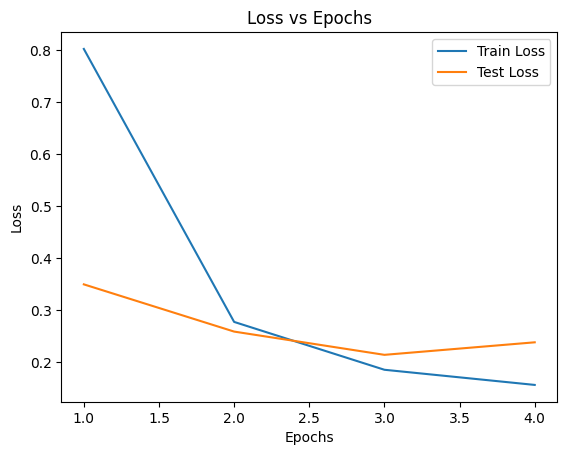

In [ ]:
# Plot the loss vs epochs
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(train_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()


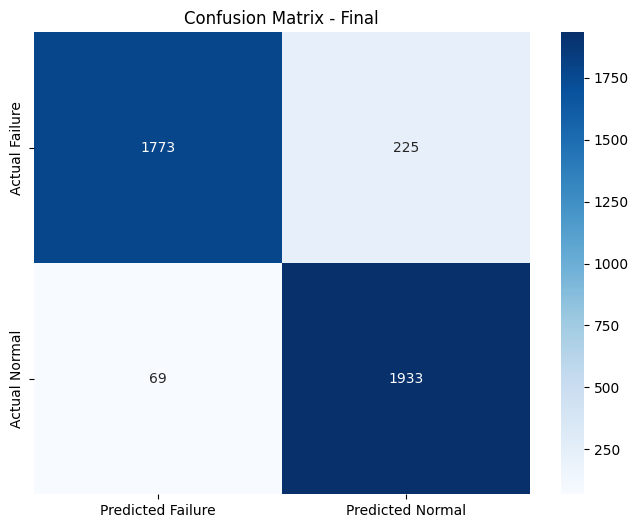

In [ ]:


#  ( existing code)

# (modified to print confusion matrix only once)


# Confusion Matrix (printed only once after all epochs)
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Failure', 'Predicted Normal'],
            yticklabels=['Actual Failure', 'Actual Normal'])
plt.title("Confusion Matrix - Final") # Added - Final to indicate it is the last epoch
plt.show()


In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.8957
Recall: 0.9655
F1-Score: 0.9293


In [ ]:
# ############ NEW CODE WITH SEEDS##########################
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, random_split
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# seeds = [0, 1, 42, 1234, 10]
# #seeds = [42, 1234, 10, 1]

# for seed in seeds:
#     print(f"\nRunning training with seed: {seed}")
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     np.random.seed(seed)

#     test_size = int(0.2 * len(dataset))
#     train_size = len(dataset) - test_size
#     train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#     model = ComplexConvNet()
#     criterion = nn.BCEWithLogitsLoss()
#     optimizer = optim.Adam(model.parameters(), lr=1e-3)

#     num_epochs = 10
#     patience = 5
#     best_accuracy = 0
#     epochs_no_improve = 0

#     train_losses = []
#     train_accuracies = []
#     test_losses = []
#     test_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0
#         correct_train = 0
#         total_train = 0

#         for data, labels in train_loader:
#             data = data.float()
#             data = (data - data.mean(dim=-1, keepdim=True)) / (data.std(dim=-1, keepdim=True) + 1e-6)
#             data = data.to(torch.complex64)
#             labels = labels.float().unsqueeze(1)

#             optimizer.zero_grad()
#             outputs = model(data)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()
#             predicted = (torch.sigmoid(outputs) > 0.5).float()
#             total_train += labels.size(0)
#             correct_train += (predicted == labels).sum().item()

#         train_accuracy = 100 * correct_train / total_train
#         train_losses.append(train_loss / len(train_loader))
#         train_accuracies.append(train_accuracy)

#         model.eval()
#         test_loss = 0
#         correct_test = 0
#         total_test = 0
#         all_predictions = []
#         all_labels = []

#         with torch.no_grad():
#             for data, labels in test_loader:
#                 if data.ndim == 2:
#                     data = data.unsqueeze(1)
#                 elif data.ndim == 4:
#                     data = data.squeeze(1)
#                 data = data.float()
#                 data = (data - data.mean(dim=-1, keepdim=True)) / (data.std(dim=-1, keepdim=True) + 1e-6)
#                 data = data.to(torch.complex64)
#                 labels = labels.float().unsqueeze(1)

#                 outputs = model(data)
#                 loss = criterion(outputs, labels)
#                 test_loss += loss.item()
#                 predictions = (torch.sigmoid(outputs) > 0.5).float()
#                 all_predictions.extend(predictions.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())
#                 total_test += labels.size(0)
#                 correct_test += (predictions == labels).sum().item()

#         test_accuracy = 100 * correct_test / total_test
#         test_losses.append(test_loss / len(test_loader))
#         test_accuracies.append(test_accuracy)

#         print(f"Epoch {epoch+1}/{num_epochs}, "
#               f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
#               f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

#         if test_accuracy > best_accuracy:
#             best_accuracy = test_accuracy
#             epochs_no_improve = 0
#             torch.save(model.state_dict(), f'best_model_seed_{seed}.pth')
#         else:
#             epochs_no_improve += 1
#             if epochs_no_improve == patience:
#                 print(f"Early stopping at epoch {epoch+1}")
#                 break

#     cm = confusion_matrix(all_labels, all_predictions)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#                 xticklabels=['Predicted Failure', 'Predicted Normal'],
#                 yticklabels=['Actual Failure', 'Actual Normal'])
#     plt.title(f"Confusion Matrix - Final (Seed: {seed})")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.show()

#     precision = precision_score(all_labels, all_predictions)
#     recall = recall_score(all_labels, all_predictions)
#     f1 = f1_score(all_labels, all_predictions)

#     print(f"\n[Metrics for Seed {seed}]")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall:    {recall:.4f}")
#     print(f"F1-Score:  {f1:.4f}")

In [ ]:
# # import torch
# # import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, random_split
# from sklearn.metrics import accuracy_score, confusion_matrix
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt


# # Split the dataset into training and testing sets
# test_size = int(0.2 * len(dataset))
# train_size = len(dataset) - test_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# # # Create DataLoaders

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # MMMR: This need to be True always as batch optimization need data to be shuffled at the start of every epochs.
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # # Instantiate the model, optimizer, and loss function
# # model = ConvNet()
# optimizer = optim.Adam(model.parameters())
# criterion = nn.BCELoss()  # Binary Cross-Entropy Loss


In [ ]:
# # Training loop with early stopping
# num_epochs = 20  # Adjust as needed
# patience = 2  # Number of epochs with no improvement after which training will be stopped
# best_accuracy = 0
# epochs_no_improve = 0

# # Training
# train_losses = []
# train_accuracies = []
# test_losses = []
# test_accuracies = []

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     correct_train = 0
#     total_train = 0
#     for data, labels in train_loader:
#         data = data.to(torch.complex64)
#         labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
#         # print(f"Batch {batch_idx} - Data shape: {data.shape}, Labels shape: {labels.shape}, Data type: {data.dtype}, Labels shape: {labels.dtype}")

#         optimizer.zero_grad()
#         outputs = model(data)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#         predicted = (outputs > 0.5).float()
#         total_train += labels.size(0)
#         correct_train += (predicted == labels).sum().item()

#     train_accuracy = 100 * correct_train / total_train
#     train_losses.append(train_loss / len(train_loader))
#     train_accuracies.append(train_accuracy)

#     # Evaluation
#     model.eval()
#     test_loss = 0
#     correct_test = 0
#     total_test = 0
#     all_predictions = []
#     all_labels = []
#     with torch.no_grad():
#         for data, labels in test_loader:
#             #data = data.float()  # convert data to float
#             data = data.to(torch.complex64)
#             labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
#             outputs = model(data)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item()
#             predictions = (outputs > 0.5).float()  # convert output to 0,1 values
#             all_predictions.extend(predictions.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
#             total_test += labels.size(0)
#             correct_test += (predictions == labels).sum().item()

#     test_accuracy = 100 * correct_test / total_test
#     test_losses.append(test_loss / len(test_loader))
#     test_accuracies.append(test_accuracy)


#     print(f"Epoch {epoch+1}/{num_epochs}, "
#           f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
#           f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")



#      # Early stopping check
#     if test_accuracy > best_accuracy:
#         best_accuracy = test_accuracy
#         epochs_no_improve = 0
#         # Save the model weights
#         torch.save(model.state_dict(), 'best_model_weights.pth')
#     else:
#         epochs_no_improve += 1
#     if epochs_no_improve == patience:
#         print(f"Early stopping at epoch {epoch+1}")
#         break

#     # Confusion Matrix (optional - uncomment if you want to see it per epoch)
#     # cm = confusion_matrix(all_labels, all_predictions)
#     # plt.figure(figsize=(8, 6))
#     # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#     #             xticklabels=['Predicted Failure', 'Predicted Normal'],
#     #             yticklabels=['Actual Failure', 'Actual Normal'])
#     # plt.title(f"Confusion Matrix - Epoch {epoch+1}")
#     # plt.show()

In [ ]:


# #  ( existing code)

# # (modified to print confusion matrix only once)


# # Confusion Matrix (printed only once after all epochs)
# cm = confusion_matrix(all_labels, all_predictions)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#             xticklabels=['Predicted Failure', 'Predicted Normal'],
#             yticklabels=['Actual Failure', 'Actual Normal'])
# plt.title("Confusion Matrix - Final") # Added - Final to indicate it is the last epoch
# plt.show()


In [ ]:

# from sklearn.metrics import precision_score, recall_score, f1_score

# # Calculate precision, recall, and F1-score
# precision = precision_score(all_labels, all_predictions)
# recall = recall_score(all_labels, all_predictions)
# f1 = f1_score(all_labels, all_predictions)

# print(f"\nPrecision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1:.4f}")

**FOURIER TRANSFORM**

In [ ]:
from torch.utils.data import DataLoader
import time

start= time.time()
### Your code goes here #################################################################################################


# Create the dataset
dataset = Dataset_custom_transform('/content/normal_3d_array.npy', '/content/failure_3d_array.npy', preprocessing_flag='FFT')

# Create a DataLoader
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Iterate through the DataLoader
for batch_idx, (data, labels) in enumerate(dataloader):
    data = data.to(torch.complex64)
    labels = labels.float().unsqueeze(1)
    print(f"Batch {batch_idx} - Data shape: {data.shape}, Labels shape: {labels.shape}, Data type: {data.dtype}, Labels shape: {labels.dtype}")
    # Now you have batches of data and labels ready for your model
    # ... your model training code here ...
    break #remove to run through the entire dataloader

#################################################################################################################################

end = time.time()
print("Time taken", end- start)




Batch 0 - Data shape: torch.Size([100, 3, 1024]), Labels shape: torch.Size([100, 1]), Data type: torch.complex64, Labels shape: torch.float32
Time taken 0.020874977111816406


In [ ]:
## USING COMPLEX CON NET IN FFT TOO ##

In [ ]:
# import torch
# import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Split the dataset into training and testing sets
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# # Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # MMMR: This need to be True always as batch optimization need data to be shuffled at the start of every epochs.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Instantiate the model, optimizer, and loss function
model = ComplexConvNet(in_channels=3)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss


In [ ]:
# Training loop with early stopping
num_epochs = 10  # Adjust as needed
patience = 1  # Number of epochs with no improvement after which training will be stopped
best_accuracy = 0
epochs_no_improve = 0

# Training
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for data, labels in train_loader:
        data = data.to(torch.complex64)
        labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
        # print(f"Batch {batch_idx} - Data shape: {data.shape}, Labels shape: {labels.shape}, Data type: {data.dtype}, Labels shape: {labels.dtype}")

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluation
    model.eval() ## USING COMPLEX CON NET IN FFT TOO ##
    test_loss = 0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data, labels in test_loader:
            #data = data.float()  # convert data to float
            data = data.to(torch.complex64)
            labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predictions = (outputs > 0.5).float()  # convert output to 0,1 values
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predictions == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")



     # Early stopping check
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        epochs_no_improve = 0
        # Save the model weights
        torch.save(model.state_dict(), 'best_model_weights.pth')
    else:
        epochs_no_improve += 1
    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Confusion Matrix (optional - uncomment if you want to see it per epoch)
    # cm = confusion_matrix(all_labels, all_predictions)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
    #             xticklabels=['Predicted Failure', 'Predicted Normal'],
    #             yticklabels=['Actual Failure', 'Actual Normal'])
    # plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    # plt.show()

Epoch 1/10, Train Loss: 37.9347, Train Acc: 49.98%, Test Loss: 38.4375, Test Acc: 49.90%
Epoch 2/10, Train Loss: 38.2133, Train Acc: 50.02%, Test Loss: 38.3895, Test Acc: 49.90%
Early stopping at epoch 2


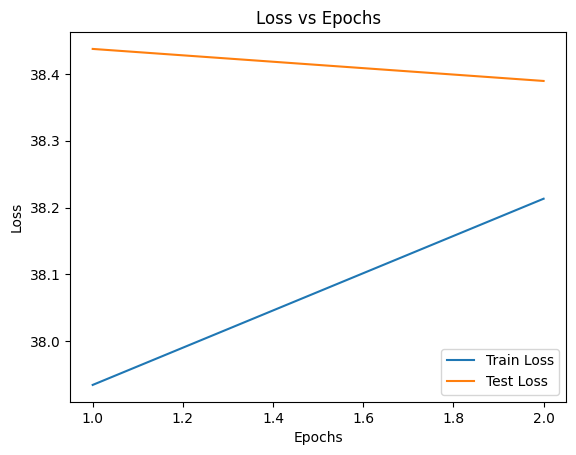

In [ ]:
# Plot the loss vs epochs
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(train_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()


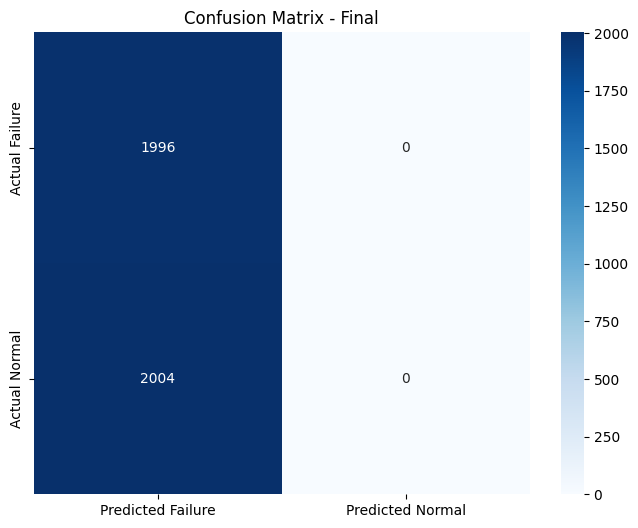

In [ ]:


#  ( existing code)

# (modified to print confusion matrix only once)


# Confusion Matrix (printed only once after all epochs)
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Failure', 'Predicted Normal'],
            yticklabels=['Actual Failure', 'Actual Normal'])
plt.title("Confusion Matrix - Final") # Added - Final to indicate it is the last epoch
plt.show()


In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, random_split
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# seeds = [0, 1, 42, 1234, 10]
# #seeds = [1, 42, 1234, 10]

# for seed in seeds:
#     print(f"\nRunning training with seed: {seed}")
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     np.random.seed(seed)

#     test_size = int(0.2 * len(dataset))
#     train_size = len(dataset) - test_size
#     train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#     model = ComplexConvNet()
#     criterion = nn.BCEWithLogitsLoss()
#     optimizer = optim.Adam(model.parameters(), lr=1e-3)

#     num_epochs = 10
#     patience = 5
#     best_accuracy = 0
#     epochs_no_improve = 0

#     train_losses = []
#     train_accuracies = []
#     test_losses = []
#     test_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0
#         correct_train = 0
#         total_train = 0

#         for data, labels in train_loader:
#             data = data.float()
#             data = (data - data.mean(dim=-1, keepdim=True)) / (data.std(dim=-1, keepdim=True) + 1e-6)
#             data = data.to(torch.complex64)
#             labels = labels.float().unsqueeze(1)

#             optimizer.zero_grad()
#             outputs = model(data)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()
#             predicted = (torch.sigmoid(outputs) > 0.5).float()
#             total_train += labels.size(0)
#             correct_train += (predicted == labels).sum().item()

#         train_accuracy = 100 * correct_train / total_train
#         train_losses.append(train_loss / len(train_loader))
#         train_accuracies.append(train_accuracy)

#         model.eval()
#         test_loss = 0
#         correct_test = 0
#         total_test = 0
#         all_predictions = []
#         all_labels = []

#         with torch.no_grad():
#             for data, labels in test_loader:
#                 if data.ndim == 2:
#                     data = data.unsqueeze(1)
#                 elif data.ndim == 4:
#                     data = data.squeeze(1)
#                 data = data.float()
#                 data = (data - data.mean(dim=-1, keepdim=True)) / (data.std(dim=-1, keepdim=True) + 1e-6)
#                 data = data.to(torch.complex64)
#                 labels = labels.float().unsqueeze(1)

#                 outputs = model(data)
#                 loss = criterion(outputs, labels)
#                 test_loss += loss.item()
#                 predictions = (torch.sigmoid(outputs) > 0.5).float()
#                 all_predictions.extend(predictions.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())
#                 total_test += labels.size(0)
#                 correct_test += (predictions == labels).sum().item()

#         test_accuracy = 100 * correct_test / total_test
#         test_losses.append(test_loss / len(test_loader))
#         test_accuracies.append(test_accuracy)

#         print(f"Epoch {epoch+1}/{num_epochs}, "
#               f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
#               f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

#         if test_accuracy > best_accuracy:
#             best_accuracy = test_accuracy
#             epochs_no_improve = 0
#             torch.save(model.state_dict(), f'best_model_seed_{seed}.pth')
#         else:
#             epochs_no_improve += 1
#             if epochs_no_improve == patience:
#                 print(f"Early stopping at epoch {epoch+1}")
#                 break

#     cm = confusion_matrix(all_labels, all_predictions)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#                 xticklabels=['Predicted Failure', 'Predicted Normal'],
#                 yticklabels=['Actual Failure', 'Actual Normal'])
#     plt.title(f"Confusion Matrix - Final (Seed: {seed})")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.show()

#     precision = precision_score(all_labels, all_predictions)
#     recall = recall_score(all_labels, all_predictions)
#     f1 = f1_score(all_labels, all_predictions)

#     print(f"\n[Metrics for Seed {seed}]")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall:    {recall:.4f}")
#     print(f"F1-Score:  {f1:.4f}")

**DCT**


In [ ]:
from torch.utils.data import DataLoader
import time

start= time.time()
### Your code goes here #################################################################################################


# Create the dataset
dataset = Dataset_custom_transform('/content/normal_3d_array.npy', '/content/failure_3d_array.npy', preprocessing_flag='DCT')

# Create a DataLoader
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Iterate through the DataLoader
for batch_idx, (data, labels) in enumerate(dataloader):
    data = data.to(torch.complex64)
    labels = labels.float().unsqueeze(1)
    print(f"Batch {batch_idx} - Data shape: {data.shape}, Labels shape: {labels.shape}, Data type: {data.dtype}, Labels shape: {labels.dtype}")
    # Now you have batches of data and labels ready for your model
    # ... your model training code here ...
    break #remove to run through the entire dataloader

#################################################################################################################################

end = time.time()
print("Time taken", end- start)




Batch 0 - Data shape: torch.Size([100, 3, 1024]), Labels shape: torch.Size([100, 1]), Data type: torch.complex64, Labels shape: torch.float32
Time taken 0.03339743614196777


In [ ]:


class ConvNet(nn.Module):
    def __init__(self, in_channels=3):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64 * 256, 128) # Adjust input size based on pooling
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1) # Output size 1 for binary classification
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 256)  # Adjust input size based on pooling
        x = self.relu3(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


model = ConvNet()
#print(model(failure_tensor).shape) # Now it should print a valid shape
# Example forward pass (replace with our actual input)
#output = model(failure_tensor[0].unsqueeze(0))  # Unsqueezingto add a batch dimension
#print(output)



# Example usage (assuming your data is in 'failure_array'):
# Reshape the data to (samples, channels, length)
#failure_array = failure_array.reshape(failure_array.shape[0], 3, 1024) # Correct the reshape
#normal_array = normal_array.reshape(normal_array.shape[0], 3, 1024)

# Convert NumPy arrays to PyTorch tensors
#failure_tensor = torch.tensor(failure_array, dtype=torch.float32)
# Instantiate the model

In [ ]:
# import torch
# import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Split the dataset into training and testing sets
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# # Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # MMMR: This need to be True always as batch optimization need data to be shuffled at the start of every epochs.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Instantiate the model, optimizer, and loss function
model = ConvNet(in_channels=3)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss


In [ ]:
#Training loop with early stopping
num_epochs = 10  #Adjust as needed
patience = 1  #Number of epochs with no improvement after which training will be stopped
best_accuracy = 0
epochs_no_improve = 0

# Training
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for data, labels in train_loader:
        #data = data.to(torch.complex64)
        data = data.float()
        labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
        # print(f"Batch {batch_idx} - Data shape: {data.shape}, Labels shape: {labels.shape}, Data type: {data.dtype}, Labels shape: {labels.dtype}")

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluation
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.float()  # convert data to float
            #data = data.to(torch.complex64)
            labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predictions = (outputs > 0.5).float()  # convert output to 0,1 values
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predictions == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")



     # Early stopping check
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        epochs_no_improve = 0
        # Save the model weights
        torch.save(model.state_dict(), 'best_model_weights.pth')
    else:
        epochs_no_improve += 1
    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Confusion Matrix (optional - uncomment if you want to see it per epoch)
    # cm = confusion_matrix(all_labels, all_predictions)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
    #             xticklabels=['Predicted Failure', 'Predicted Normal'],
    #             yticklabels=['Actual Failure', 'Actual Normal'])
    # plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    # plt.show()

Epoch 1/10, Train Loss: 2.1430, Train Acc: 85.56%, Test Loss: 0.1923, Test Acc: 93.22%
Epoch 2/10, Train Loss: 0.1603, Train Acc: 94.35%, Test Loss: 0.1809, Test Acc: 94.30%
Epoch 3/10, Train Loss: 0.1357, Train Acc: 95.34%, Test Loss: 0.1947, Test Acc: 93.67%
Early stopping at epoch 3


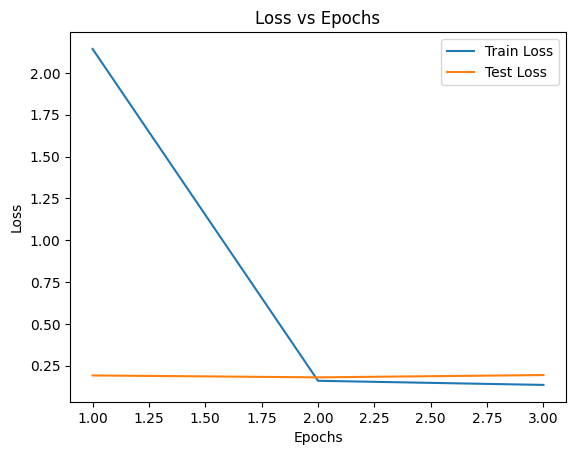

In [ ]:
# Plot the loss vs epochs
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(train_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()


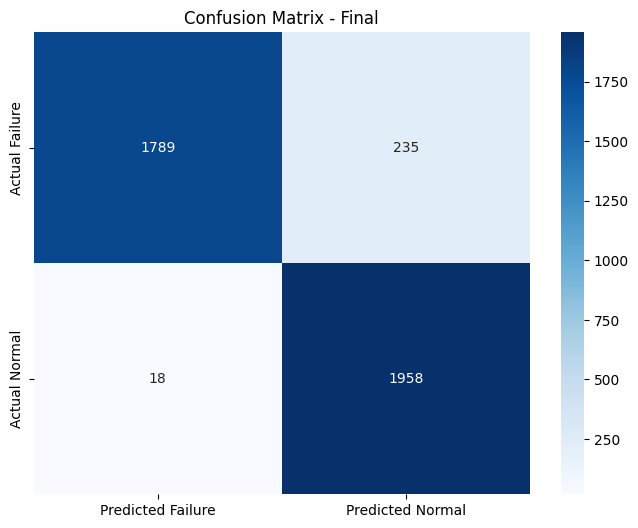

In [ ]:


#  ( existing code)

# (modified to print confusion matrix only once)


# Confusion Matrix (printed only once after all epochs)
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Failure', 'Predicted Normal'],
            yticklabels=['Actual Failure', 'Actual Normal'])
plt.title("Confusion Matrix - Final") # Added - Final to indicate it is the last epoch
plt.show()


In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.8928
Recall: 0.9909
F1-Score: 0.9393


**DST code**

In [ ]:
from torch.utils.data import DataLoader
import time

start= time.time()
### Your code goes here #################################################################################################


# Create the dataset
dataset = Dataset_custom_transform('/content/normal_3d_array.npy', '/content/failure_3d_array.npy', preprocessing_flag='DST')

# Create a DataLoader
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Iterate through the DataLoader
for batch_idx, (data, labels) in enumerate(dataloader):
    data = data.to(torch.complex64)
    labels = labels.float().unsqueeze(1)
    print(f"Batch {batch_idx} - Data shape: {data.shape}, Labels shape: {labels.shape}, Data type: {data.dtype}, Labels shape: {labels.dtype}")
    # Now you have batches of data and labels ready for your model
    # ... your model training code here ...
    break #remove to run through the entire dataloader

#################################################################################################################################

end = time.time()
print("Time taken", end- start)




Batch 0 - Data shape: torch.Size([100, 3, 1024]), Labels shape: torch.Size([100, 1]), Data type: torch.complex64, Labels shape: torch.float32
Time taken 0.012703895568847656


In [ ]:
# import torch
# import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Split the dataset into training and testing sets
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# # Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # MMMR: This need to be True always as batch optimization need data to be shuffled at the start of every epochs.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Instantiate the model, optimizer, and loss function
model = ConvNet()
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss


In [ ]:
# Training loop with early stopping
num_epochs = 10  # Adjust as needed
patience = 1  # Number of epochs with no improvement after which training will be stopped
best_accuracy = 0
epochs_no_improve = 0

# Training
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for data, labels in train_loader:
        data = data.float()
        labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
        # print(f"Batch {batch_idx} - Data shape: {data.shape}, Labels shape: {labels.shape}, Data type: {data.dtype}, Labels shape: {labels.dtype}")

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluation
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.float()  # convert data to float
            #data = data.to(torch.complex64)
            labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predictions = (outputs > 0.5).float()  # convert output to 0,1 values
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predictions == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")


 # Inside the training loop, after the evaluation:
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        epochs_no_improve = 0
        # Save the model weights
        torch.save(model.state_dict(), 'best_model_weights.pth')
    else:
        epochs_no_improve += 1
    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Confusion Matrix (optional - uncomment if you want to see it per epoch aft every epoch)
    # cm = confusion_matrix(all_labels, all_predictions)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
    #             xticklabels=['Predicted Failure', 'Predicted Normal'],
    #             yticklabels=['Actual Failure', 'Actual Normal'])
    # plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    # plt.show()

Epoch 1/10, Train Loss: 24.7405, Train Acc: 58.73%, Test Loss: 0.6150, Test Acc: 77.33%
Epoch 2/10, Train Loss: 0.5147, Train Acc: 86.07%, Test Loss: 0.4423, Test Acc: 89.35%
Epoch 3/10, Train Loss: 0.4238, Train Acc: 90.59%, Test Loss: 0.3847, Test Acc: 92.03%
Epoch 4/10, Train Loss: 0.3654, Train Acc: 92.41%, Test Loss: 0.3293, Test Acc: 93.55%
Epoch 5/10, Train Loss: 0.3198, Train Acc: 93.81%, Test Loss: 0.3097, Test Acc: 94.03%
Epoch 6/10, Train Loss: 0.2862, Train Acc: 94.25%, Test Loss: 0.2584, Test Acc: 95.05%
Epoch 7/10, Train Loss: 0.2564, Train Acc: 95.37%, Test Loss: 0.3019, Test Acc: 92.10%
Early stopping at epoch 7


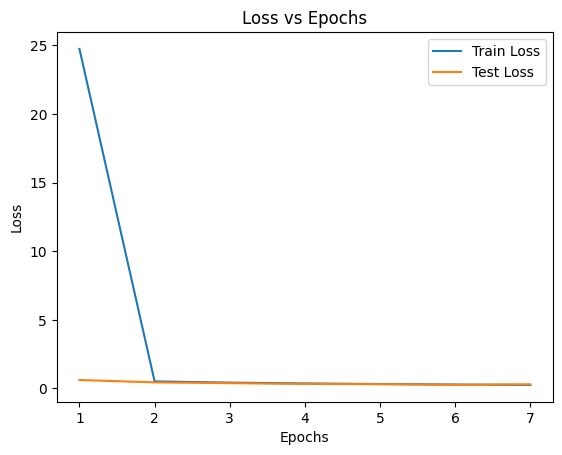

In [ ]:
# Plot the loss vs epochs
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(train_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()


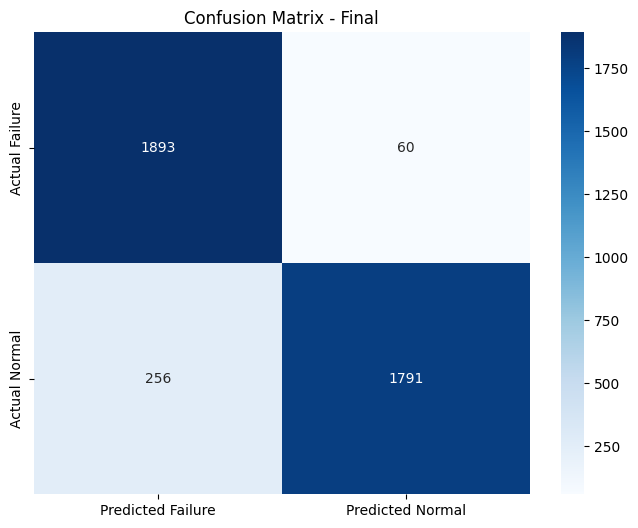

In [ ]:


#  ( existing code)

# (modified to print confusion matrix only once)


# Confusion Matrix (printed only once after all epochs)
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Failure', 'Predicted Normal'],
            yticklabels=['Actual Failure', 'Actual Normal'])
plt.title("Confusion Matrix - Final") # Added - Final to indicate it is the last epoch
plt.show()


In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.9676
Recall: 0.8749
F1-Score: 0.9189


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, random_split
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# seeds = [0, 1, 42, 1234, 10]
# #seeds = [1, 42, 1234, 10]

# for seed in seeds:
#     print(f"\nRunning training with seed: {seed}")
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     np.random.seed(seed)

#     test_size = int(0.2 * len(dataset))
#     train_size = len(dataset) - test_size
#     train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#     model = ComplexConvNet()
#     criterion = nn.BCEWithLogitsLoss()
#     optimizer = optim.Adam(model.parameters(), lr=1e-3)

#     num_epochs = 10
#     patience = 5
#     best_accuracy = 0
#     epochs_no_improve = 0

#     train_losses = []
#     train_accuracies = []
#     test_losses = []
#     test_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0
#         correct_train = 0
#         total_train = 0

#         for data, labels in train_loader:
#             data = data.float()
#             data = (data - data.mean(dim=-1, keepdim=True)) / (data.std(dim=-1, keepdim=True) + 1e-6)
#             data = data.to(torch.complex64)
#             labels = labels.float().unsqueeze(1)

#             optimizer.zero_grad()
#             outputs = model(data)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()
#             predicted = (torch.sigmoid(outputs) > 0.5).float()
#             total_train += labels.size(0)
#             correct_train += (predicted == labels).sum().item()

#         train_accuracy = 100 * correct_train / total_train
#         train_losses.append(train_loss / len(train_loader))
#         train_accuracies.append(train_accuracy)

#         model.eval()
#         test_loss = 0
#         correct_test = 0
#         total_test = 0
#         all_predictions = []
#         all_labels = []

#         with torch.no_grad():
#             for data, labels in test_loader:
#                 if data.ndim == 2:
#                     data = data.unsqueeze(1)
#                 elif data.ndim == 4:
#                     data = data.squeeze(1)
#                 data = data.float()
#                 data = (data - data.mean(dim=-1, keepdim=True)) / (data.std(dim=-1, keepdim=True) + 1e-6)
#                 data = data.to(torch.complex64)
#                 labels = labels.float().unsqueeze(1)

#                 outputs = model(data)
#                 loss = criterion(outputs, labels)
#                 test_loss += loss.item()
#                 predictions = (torch.sigmoid(outputs) > 0.5).float()
#                 all_predictions.extend(predictions.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())
#                 total_test += labels.size(0)
#                 correct_test += (predictions == labels).sum().item()

#         test_accuracy = 100 * correct_test / total_test
#         test_losses.append(test_loss / len(test_loader))
#         test_accuracies.append(test_accuracy)

#         print(f"Epoch {epoch+1}/{num_epochs}, "
#               f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
#               f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

#         if test_accuracy > best_accuracy:
#             best_accuracy = test_accuracy
#             epochs_no_improve = 0
#             torch.save(model.state_dict(), f'best_model_seed_{seed}.pth')
#         else:
#             epochs_no_improve += 1
#             if epochs_no_improve == patience:
#                 print(f"Early stopping at epoch {epoch+1}")
#                 break

#     cm = confusion_matrix(all_labels, all_predictions)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#                 xticklabels=['Predicted Failure', 'Predicted Normal'],
#                 yticklabels=['Actual Failure', 'Actual Normal'])
#     plt.title(f"Confusion Matrix - Final (Seed: {seed})")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.show()

#     precision = precision_score(all_labels, all_predictions)
#     recall = recall_score(all_labels, all_predictions)
#     f1 = f1_score(all_labels, all_predictions)

#     print(f"\n[Metrics for Seed {seed}]")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall:    {recall:.4f}")
#     print(f"F1-Score:  {f1:.4f}")

**WAVELET**

In [ ]:
from torch.utils.data import DataLoader
import time

start= time.time()
### Your code goes here #################################################################################################


# Create the dataset
dataset = Dataset_custom_transform('/content/normal_3d_array.npy', '/content/failure_3d_array.npy', preprocessing_flag='Wavelet')

# Create a DataLoader
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Iterate through the DataLoader
for batch_idx, (data, labels) in enumerate(dataloader):
    data = data.to(torch.complex64)
    labels = labels.float().unsqueeze(1)
    print(f"Batch {batch_idx} - Data shape: {data.shape}, Labels shape: {labels.shape}, Data type: {data.dtype}, Labels shape: {labels.dtype}")
    # Now you have batches of data and labels ready for your model
    # ... your model training code here ...
    break #remove to run through the entire dataloader

#################################################################################################################################

end = time.time()
print("Time taken", end- start)




Batch 0 - Data shape: torch.Size([100, 3, 1024]), Labels shape: torch.Size([100, 1]), Data type: torch.complex64, Labels shape: torch.float32
Time taken 0.07648491859436035


In [ ]:
# import torch
# import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Split the dataset into training and testing sets
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# # Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # MMMR: This need to be True always as batch optimization need data to be shuffled at the start of every epochs.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Instantiate the model, optimizer, and loss function
model = ComplexConvNet()
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss


In [ ]:
# Training loop with early stopping
num_epochs = 10  # Adjust as needed
patience = 1  # Number of epochs with no improvement after which training will be stopped
best_accuracy = 0
epochs_no_improve = 0

# Training
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for data, labels in train_loader:
        data = data.to(torch.complex64)
        labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
        # print(f"Batch {batch_idx} - Data shape: {data.shape}, Labels shape: {labels.shape}, Data type: {data.dtype}, Labels shape: {labels.dtype}")

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluation
    model.eval() ## USING COMPLEX CON NET IN FFT TOO ##
    test_loss = 0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data, labels in test_loader:
            #data = data.float()  # convert data to float
            data = data.to(torch.complex64)
            labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predictions = (outputs > 0.5).float()  # convert output to 0,1 values
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predictions == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)


    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")



     # Early stopping check
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        epochs_no_improve = 0
        # Save the model weights
        torch.save(model.state_dict(), 'best_model_weights.pth')
    else:
        epochs_no_improve += 1
    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Confusion Matrix (optional - uncomment if you want to see it per epoch)
    # cm = confusion_matrix(all_labels, all_predictions)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
    #             xticklabels=['Predicted Failure', 'Predicted Normal'],
    #             yticklabels=['Actual Failure', 'Actual Normal'])
    # plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    # plt.show()

Epoch 1/10, Train Loss: 0.4296, Train Acc: 84.70%, Test Loss: 0.2449, Test Acc: 92.17%
Epoch 2/10, Train Loss: 0.2088, Train Acc: 92.60%, Test Loss: 0.1863, Test Acc: 93.55%
Epoch 3/10, Train Loss: 0.1936, Train Acc: 93.46%, Test Loss: 0.1764, Test Acc: 93.95%
Epoch 4/10, Train Loss: 0.1459, Train Acc: 95.07%, Test Loss: 0.1741, Test Acc: 93.97%
Epoch 5/10, Train Loss: 0.1325, Train Acc: 95.51%, Test Loss: 0.1545, Test Acc: 94.90%
Epoch 6/10, Train Loss: 0.1265, Train Acc: 95.67%, Test Loss: 0.1653, Test Acc: 94.45%
Early stopping at epoch 6


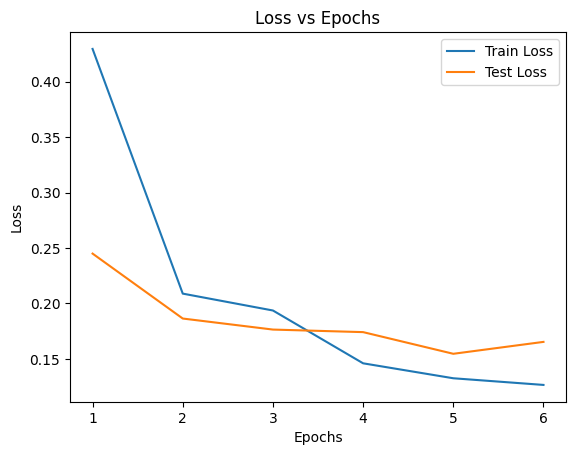

In [ ]:
# Plot the loss vs epochs
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(train_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()


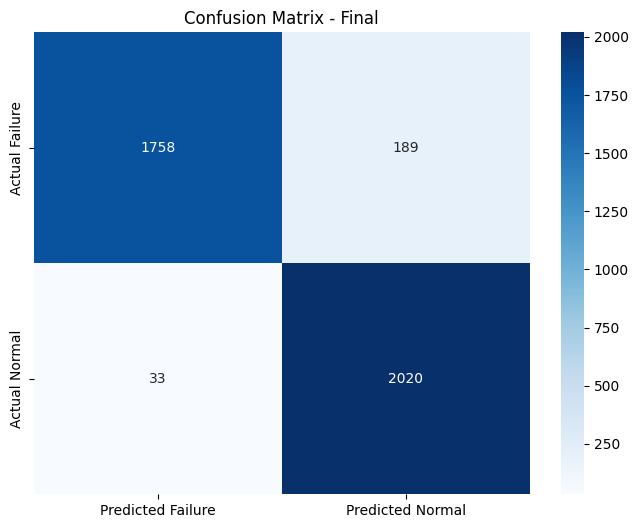

In [ ]:


#  ( existing code)

# (modified to print confusion matrix only once)


# Confusion Matrix (printed only once after all epochs)
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Failure', 'Predicted Normal'],
            yticklabels=['Actual Failure', 'Actual Normal'])
plt.title("Confusion Matrix - Final") # Added - Final to indicate it is the last epoch
plt.show()


In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.9144
Recall: 0.9839
F1-Score: 0.9479


**THE END**

In [ ]:
# # Training loop with early stopping
# num_epochs = 10  # Adjust as needed
# patience = 1  # Number of epochs with no improvement after which training will be stopped
# best_accuracy = 0
# epochs_no_improve = 0

# # Training
# train_losses = []
# train_accuracies = []
# test_losses = []
# test_accuracies = []

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     correct_train = 0
#     total_train = 0
#     for data, labels in train_loader:
#         data = data.float()
#         labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
#         # print(f"Batch {batch_idx} - Data shape: {data.shape}, Labels shape: {labels.shape}, Data type: {data.dtype}, Labels shape: {labels.dtype}")

#         optimizer.zero_grad()
#         outputs = model(data)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#         predicted = (outputs > 0.5).float()
#         total_train += labels.size(0)
#         correct_train += (predicted == labels).sum().item()

#     train_accuracy = 100 * correct_train / total_train
#     train_losses.append(train_loss / len(train_loader))
#     train_accuracies.append(train_accuracy)

#     # Evaluation
#     model.eval()
#     test_loss = 0
#     correct_test = 0
#     total_test = 0
#     all_predictions = []
#     all_labels = []
#     with torch.no_grad():
#         for data, labels in test_loader:
#             data = data.float()  # convert data to float
#             #data = data.to(torch.complex64)
#             labels = labels.float().unsqueeze(1)  # convert labels to float and unsqueeze
#             outputs = model(data)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item()
#             predictions = (outputs > 0.5).float()  # convert output to 0,1 values
#             all_predictions.extend(predictions.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
#             total_test += labels.size(0)
#             correct_test += (predictions == labels).sum().item()

#     test_accuracy = 100 * correct_test / total_test
#     test_losses.append(test_loss / len(test_loader))
#     test_accuracies.append(test_accuracy)


#     print(f"Epoch {epoch+1}/{num_epochs}, "
#           f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
#           f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")


#  # Inside the training loop, after the evaluation:
#     if test_accuracy > best_accuracy:
#         best_accuracy = test_accuracy
#         epochs_no_improve = 0
#         # Save the model weights
#         torch.save(model.state_dict(), 'best_model_weights.pth')
#     else:
#         epochs_no_improve += 1
#     if epochs_no_improve == patience:
#         print(f"Early stopping at epoch {epoch+1}")
#         break

#     # Confusion Matrix (optional - uncomment if you want to see it per epoch aft every epoch)
#     # cm = confusion_matrix(all_labels, all_predictions)
#     # plt.figure(figsize=(8, 6))
#     # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#     #             xticklabels=['Predicted Failure', 'Predicted Normal'],
#     #             yticklabels=['Actual Failure', 'Actual Normal'])
#     # plt.title(f"Confusion Matrix - Epoch {epoch+1}")
#     # plt.show()

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, random_split
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# seeds = [0, 1, 42, 1234, 10]
# #seeds = [42, 1234, 10]

# for seed in seeds:
#     print(f"\nRunning training with seed: {seed}")
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     np.random.seed(seed)

#     test_size = int(0.2 * len(dataset))
#     train_size = len(dataset) - test_size
#     train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#     model = ComplexConvNet()
#     criterion = nn.BCEWithLogitsLoss()
#     optimizer = optim.Adam(model.parameters(), lr=1e-3)

#     num_epochs = 10
#     patience = 5
#     best_accuracy = 0
#     epochs_no_improve = 0

#     train_losses = []
#     train_accuracies = []
#     test_losses = []
#     test_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0
#         correct_train = 0
#         total_train = 0

#         for data, labels in train_loader:
#             data = data.float()
#             data = (data - data.mean(dim=-1, keepdim=True)) / (data.std(dim=-1, keepdim=True) + 1e-6)
#             data = data.to(torch.complex64)
#             labels = labels.float().unsqueeze(1)

#             optimizer.zero_grad()
#             outputs = model(data)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()
#             predicted = (torch.sigmoid(outputs) > 0.5).float()
#             total_train += labels.size(0)
#             correct_train += (predicted == labels).sum().item()

#         train_accuracy = 100 * correct_train / total_train
#         train_losses.append(train_loss / len(train_loader))
#         train_accuracies.append(train_accuracy)

#         model.eval()
#         test_loss = 0
#         correct_test = 0
#         total_test = 0
#         all_predictions = []
#         all_labels = []

#         with torch.no_grad():
#             for data, labels in test_loader:
#                 if data.ndim == 2:
#                     data = data.unsqueeze(1)
#                 elif data.ndim == 4:
#                     data = data.squeeze(1)
#                 data = data.float()
#                 data = (data - data.mean(dim=-1, keepdim=True)) / (data.std(dim=-1, keepdim=True) + 1e-6)
#                 data = data.to(torch.complex64)
#                 labels = labels.float().unsqueeze(1)

#                 outputs = model(data)
#                 loss = criterion(outputs, labels)
#                 test_loss += loss.item()
#                 predictions = (torch.sigmoid(outputs) > 0.5).float()
#                 all_predictions.extend(predictions.cpu().numpy())
#                 all_labels.extend(labels.cpu().numpy())
#                 total_test += labels.size(0)
#                 correct_test += (predictions == labels).sum().item()

#         test_accuracy = 100 * correct_test / total_test
#         test_losses.append(test_loss / len(test_loader))
#         test_accuracies.append(test_accuracy)

#         print(f"Epoch {epoch+1}/{num_epochs}, "
#               f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
#               f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

#         if test_accuracy > best_accuracy:
#             best_accuracy = test_accuracy
#             epochs_no_improve = 0
#             torch.save(model.state_dict(), f'best_model_seed_{seed}.pth')
#         else:
#             epochs_no_improve += 1
#             if epochs_no_improve == patience:
#                 print(f"Early stopping at epoch {epoch+1}")
#                 break

#     cm = confusion_matrix(all_labels, all_predictions)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#                 xticklabels=['Predicted Failure', 'Predicted Normal'],
#                 yticklabels=['Actual Failure', 'Actual Normal'])
#     plt.title(f"Confusion Matrix - Final (Seed: {seed})")
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.show()

#     precision = precision_score(all_labels, all_predictions)
#     recall = recall_score(all_labels, all_predictions)
#     f1 = f1_score(all_labels, all_predictions)

#     print(f"\n[Metrics for Seed {seed}]")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall:    {recall:.4f}")
#     print(f"F1-Score:  {f1:.4f}")